Now that you’ve imported the raw taxi data, you’ll need to clean it to ensure that your predictive models are only trained using reasonable trips.

You can choose how to name and order your variables, however you should have at least the following 8 columns:

1. A categorical variable that records the 6 taxi regions. 

2. A datetime variable that records each hour of the year for each of the taxi regions.

These first two variables establish the groups for the taxi data, such that there is only one group for each combination of region and hour. The remaining features record summary statistics for each group. You must include variables for:

3. The number of taxi pickups.

4. The number of taxi drop-offs.

5. The number of net pickups, defined as pickups minus drop-offs.

6. The mean or median distance for all pickups within the group.

7. The mean or median duration for all pickups within the group.

8. The mean or median fare for all pickups within the group.

### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import datetime
from datetime import datetime, timedelta
import scipy.stats

%matplotlib inline
#sets the default autosave frequency in seconds
%autosave 60 
sns.set_style('dark')
sns.set(font_scale=1.2)

import warnings
warnings.filterwarnings('ignore')

#import feature_engine.missing_data_imputers as mdi
#from feature_engine.outlier_removers import Winsorizer
#from feature_engine import categorical_encoders as ce

pd.set_option('display.max_columns',None)
#pd.set_option('display.max_rows',None)
pd.set_option('display.width', 1000)

np.random.seed(0)
np.set_printoptions(suppress=True)

Autosaving every 60 seconds


In [2]:
df = pd.read_csv("focus.csv",parse_dates=['tpep_pickup_datetime','tpep_dropoff_datetime'], dayfirst=True)

In [3]:
df

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RateCodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,2,2015-01-29 20:30:00,2015-01-29 20:54:00,2,12.74,-73.790,JFK Airport,4,N,-73.655937,40.70500565,1,47.5,0.5,0.5,9.60,0.00,0.3,58.40
1,1,2015-01-01 17:21:00,2015-01-01 17:53:00,1,17.50,-73.790,JFK Airport,2,N,-73.992577,40.7533493,1,52.0,0.0,0.5,7.00,5.33,0.0,65.13
2,1,2015-01-18 01:08:00,2015-01-18 01:38:00,2,18.50,-73.782,JFK Airport,1,N,-73.885918,40.81613922,1,51.0,0.5,0.5,0.00,5.33,0.3,57.63
3,1,2015-01-13 16:08:00,2015-01-13 16:37:00,1,14.80,-73.788,JFK Airport,1,N,-73.940056,40.6059494,2,41.0,0.0,0.5,0.00,0.00,0.3,41.80
4,1,2015-01-29 00:42:00,2015-01-29 01:04:00,1,14.30,-73.779,JFK Airport,1,N,-73.908669,40.7676506,1,39.5,0.5,0.5,0.00,0.00,0.3,40.80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68563,2,2015-01-10 19:45:00,2015-01-10 19:53:00,1,1.69,-73.961,Upper East Side,1,N,-73.973541,40.78978729,2,8.0,0.0,0.5,0.00,0.00,0.3,8.80
68564,1,2015-01-03 16:39:00,2015-01-03 16:57:00,1,1.80,-73.982,Upper East Side,1,N,-73.987061,40.75112152,1,12.5,0.0,0.5,2.00,0.00,0.0,15.30
68565,2,2015-01-15 18:53:00,2015-01-15 19:00:00,5,1.54,-73.982,Upper East Side,1,N,-73.995934,40.75386429,1,7.5,1.0,0.5,1.70,0.00,0.3,11.00
68566,2,2015-01-15 18:56:00,2015-01-15 19:01:00,1,0.78,-73.979,Upper East Side,1,N,-73.987503,40.76572037,1,5.5,1.0,0.5,1.25,0.00,0.3,8.55


## Exploratory Data Analysis

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68568 entries, 0 to 68567
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   VendorID               68568 non-null  int64         
 1   tpep_pickup_datetime   68568 non-null  datetime64[ns]
 2   tpep_dropoff_datetime  68568 non-null  datetime64[ns]
 3   passenger_count        68568 non-null  int64         
 4   trip_distance          68568 non-null  float64       
 5   pickup_longitude       68568 non-null  float64       
 6   pickup_latitude        68568 non-null  object        
 7   RateCodeID             68568 non-null  int64         
 8   store_and_fwd_flag     68568 non-null  object        
 9   dropoff_longitude      68568 non-null  float64       
 10  dropoff_latitude       68568 non-null  object        
 11  payment_type           68568 non-null  int64         
 12  fare_amount            68568 non-null  float64       
 13  e

In [5]:
df.describe()

,VendorID,passenger_count,trip_distance,pickup_longitude,RateCodeID,dropoff_longitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
count,68568.000000,68568.000000,6.856800e+04,68568.000000,68568.000000,68568.000000,68568.000000,68568.000000,68568.000000,68568.000000,68568.000000,68568.000000,68568.000000,68568.000000
mean,1.531516,1.690424,5.194054e+01,-73.957336,1.060043,-73.830589,1.415675,13.839213,0.285746,0.497805,1.760108,0.492165,0.283619,17.174227
std,0.499009,1.346843,1.267113e+04,0.053139,0.481456,3.205633,0.505348,13.059612,0.365959,0.035192,2.775889,1.642264,0.068161,16.001486
min,1.000000,0.000000,0.000000e+00,-74.148000,1.000000,-75.304771,1.000000,-52.000000,-1.000000,-0.500000,0.000000,0.000000,0.000000,-52.800000
25%,1.000000,1.000000,1.000000e+00,-73.985000,1.000000,-73.988327,1.000000,6.500000,0.000000,0.500000,0.000000,0.000000,0.300000,8.160000
50%,2.000000,1.000000,1.700000e+00,-73.974000,1.000000,-73.977402,1.000000,9.000000,0.000000,0.500000,1.000000,0.000000,0.300000,11.300000
75%,2.000000,2.000000,3.400000e+00,-73.960000,1.000000,-73.960524,2.000000,14.500000,0.500000,0.500000,2.160000,0.000000,0.300000,17.800000
max,2.000000,6.000000,3.318000e+06,-73.546000,99.000000,0.000000,4.000000,570.080000,1.000000,0.500000,94.510000,28.750000,0.300000,590.380000


In [6]:
df.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count', 'trip_distance', 'pickup_longitude', 'pickup_latitude', 'RateCodeID', 'store_and_fwd_flag', 'dropoff_longitude', 'dropoff_latitude', 'payment_type', 'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount'], dtype='object')

## Feature Engineering

In [7]:
#df = pd.read_csv("focus2.csv")

In [8]:
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RateCodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,2,2015-01-29 20:30:00,2015-01-29 20:54:00,2,12.74,-73.790,JFK Airport,4,N,-73.655937,40.70500565,1,47.5,0.5,0.5,9.6,0.00,0.3,58.40
1,1,2015-01-01 17:21:00,2015-01-01 17:53:00,1,17.50,-73.790,JFK Airport,2,N,-73.992577,40.7533493,1,52.0,0.0,0.5,7.0,5.33,0.0,65.13
2,1,2015-01-18 01:08:00,2015-01-18 01:38:00,2,18.50,-73.782,JFK Airport,1,N,-73.885918,40.81613922,1,51.0,0.5,0.5,0.0,5.33,0.3,57.63
3,1,2015-01-13 16:08:00,2015-01-13 16:37:00,1,14.80,-73.788,JFK Airport,1,N,-73.940056,40.6059494,2,41.0,0.0,0.5,0.0,0.00,0.3,41.80
4,1,2015-01-29 00:42:00,2015-01-29 01:04:00,1,14.30,-73.779,JFK Airport,1,N,-73.908669,40.7676506,1,39.5,0.5,0.5,0.0,0.00,0.3,40.80


In [9]:
df.columns = ['vendorID', 'pickup_time', 'dropoff_time', 'passenger_count', 'trip_distance', 'pickup_longitude', 'pickup_location', 'ratecodeid', 'store_and_fwd_flag', 'dropoff_longitude', 'dropoff_latitude', 'payment_type', 'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount']

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68568 entries, 0 to 68567
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   vendorID               68568 non-null  int64         
 1   pickup_time            68568 non-null  datetime64[ns]
 2   dropoff_time           68568 non-null  datetime64[ns]
 3   passenger_count        68568 non-null  int64         
 4   trip_distance          68568 non-null  float64       
 5   pickup_longitude       68568 non-null  float64       
 6   pickup_location        68568 non-null  object        
 7   ratecodeid             68568 non-null  int64         
 8   store_and_fwd_flag     68568 non-null  object        
 9   dropoff_longitude      68568 non-null  float64       
 10  dropoff_latitude       68568 non-null  object        
 11  payment_type           68568 non-null  int64         
 12  fare_amount            68568 non-null  float64       
 13  e

In [11]:
df["pickup_time"] = pd.to_datetime(df["pickup_time"])

In [12]:
df["dropoff_time"] = pd.to_datetime(df["dropoff_time"])

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68568 entries, 0 to 68567
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   vendorID               68568 non-null  int64         
 1   pickup_time            68568 non-null  datetime64[ns]
 2   dropoff_time           68568 non-null  datetime64[ns]
 3   passenger_count        68568 non-null  int64         
 4   trip_distance          68568 non-null  float64       
 5   pickup_longitude       68568 non-null  float64       
 6   pickup_location        68568 non-null  object        
 7   ratecodeid             68568 non-null  int64         
 8   store_and_fwd_flag     68568 non-null  object        
 9   dropoff_longitude      68568 non-null  float64       
 10  dropoff_latitude       68568 non-null  object        
 11  payment_type           68568 non-null  int64         
 12  fare_amount            68568 non-null  float64       
 13  e

In [14]:
df['duration'] = ((df.dropoff_time - df.pickup_time).dt.total_seconds()) / 60

In [15]:
df['pickupday'] = df["pickup_time"].dt.day

In [16]:
#df['pickuphour'] = df["pickup_time"].dt.hour

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68568 entries, 0 to 68567
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   vendorID               68568 non-null  int64         
 1   pickup_time            68568 non-null  datetime64[ns]
 2   dropoff_time           68568 non-null  datetime64[ns]
 3   passenger_count        68568 non-null  int64         
 4   trip_distance          68568 non-null  float64       
 5   pickup_longitude       68568 non-null  float64       
 6   pickup_location        68568 non-null  object        
 7   ratecodeid             68568 non-null  int64         
 8   store_and_fwd_flag     68568 non-null  object        
 9   dropoff_longitude      68568 non-null  float64       
 10  dropoff_latitude       68568 non-null  object        
 11  payment_type           68568 non-null  int64         
 12  fare_amount            68568 non-null  float64       
 13  e

In [18]:
df.head()

,vendorID,pickup_time,dropoff_time,passenger_count,trip_distance,pickup_longitude,pickup_location,ratecodeid,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,duration,pickupday
0,2,2015-01-29 20:30:00,2015-01-29 20:54:00,2,12.74,-73.790,JFK Airport,4,N,-73.655937,40.70500565,1,47.5,0.5,0.5,9.6,0.00,0.3,58.40,24.0,29
1,1,2015-01-01 17:21:00,2015-01-01 17:53:00,1,17.50,-73.790,JFK Airport,2,N,-73.992577,40.7533493,1,52.0,0.0,0.5,7.0,5.33,0.0,65.13,32.0,1
2,1,2015-01-18 01:08:00,2015-01-18 01:38:00,2,18.50,-73.782,JFK Airport,1,N,-73.885918,40.81613922,1,51.0,0.5,0.5,0.0,5.33,0.3,57.63,30.0,18
3,1,2015-01-13 16:08:00,2015-01-13 16:37:00,1,14.80,-73.788,JFK Airport,1,N,-73.940056,40.6059494,2,41.0,0.0,0.5,0.0,0.00,0.3,41.80,29.0,13
4,1,2015-01-29 00:42:00,2015-01-29 01:04:00,1,14.30,-73.779,JFK Airport,1,N,-73.908669,40.7676506,1,39.5,0.5,0.5,0.0,0.00,0.3,40.80,22.0,29


In [19]:
#df.to_csv("focus2.csv", index=False)

## Data Visualization

In [20]:
df = pd.read_csv("focus2.csv")

In [21]:
df.head()

,vendorID,pickup_time,dropoff_time,passenger_count,trip_distance,pickup_longitude,pickup_location,ratecodeid,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,duration,pickupday
0,2,2015-01-29 20:30:00,2015-01-29 20:54:00,2,12.74,-73.790,JFK Airport,4,N,-73.655937,40.70500565,1,47.5,0.5,0.5,9.6,0.00,0.3,58.40,24.0,29
1,1,2015-01-01 17:21:00,2015-01-01 17:53:00,1,17.50,-73.790,JFK Airport,2,N,-73.992577,40.7533493,1,52.0,0.0,0.5,7.0,5.33,0.0,65.13,32.0,1
2,1,2015-01-18 01:08:00,2015-01-18 01:38:00,2,18.50,-73.782,JFK Airport,1,N,-73.885918,40.81613922,1,51.0,0.5,0.5,0.0,5.33,0.3,57.63,30.0,18
3,1,2015-01-13 16:08:00,2015-01-13 16:37:00,1,14.80,-73.788,JFK Airport,1,N,-73.940056,40.6059494,2,41.0,0.0,0.5,0.0,0.00,0.3,41.80,29.0,13
4,1,2015-01-29 00:42:00,2015-01-29 01:04:00,1,14.30,-73.779,JFK Airport,1,N,-73.908669,40.7676506,1,39.5,0.5,0.5,0.0,0.00,0.3,40.80,22.0,29


### Univariate Data Exploration

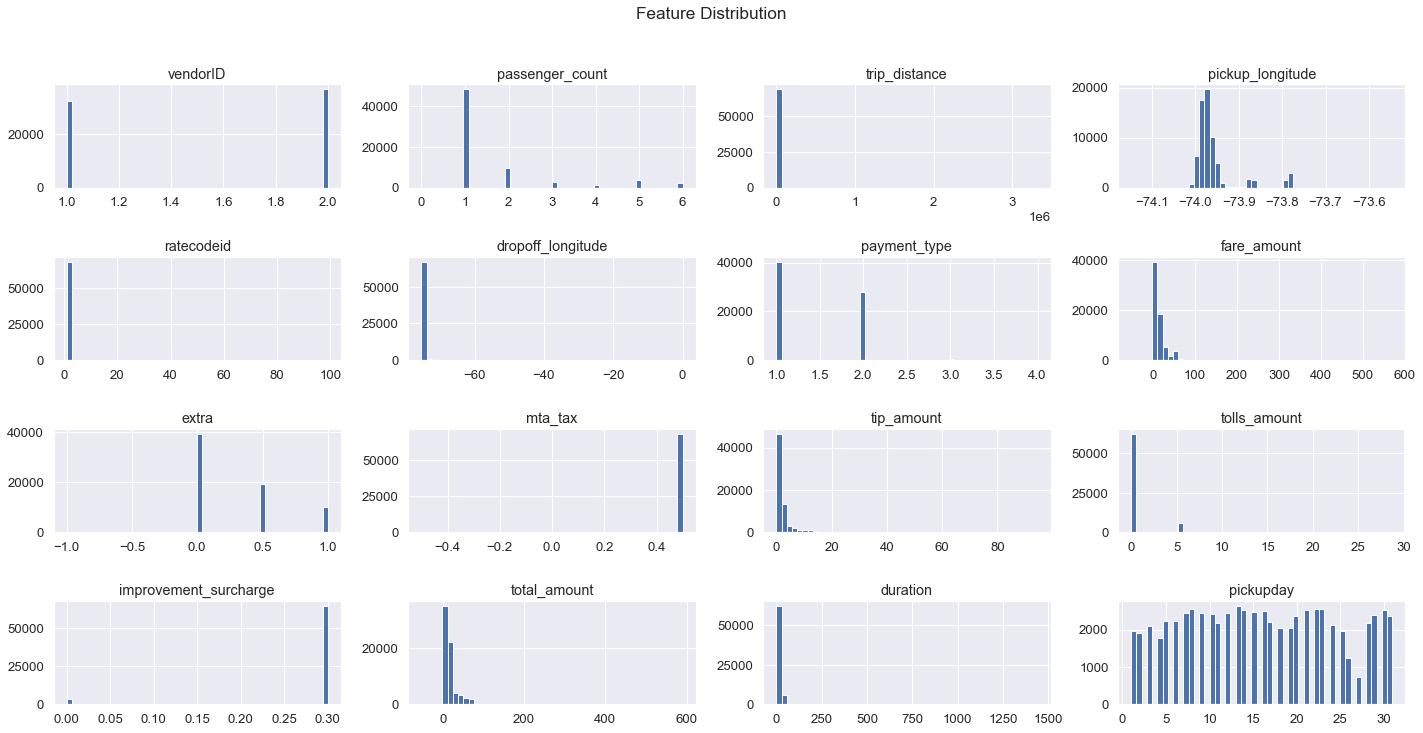

In [22]:
df.hist(bins=50, figsize=(20,10))
plt.suptitle('Feature Distribution', x=0.5, y=1.02, ha='center', fontsize='large')
plt.tight_layout()
plt.show()

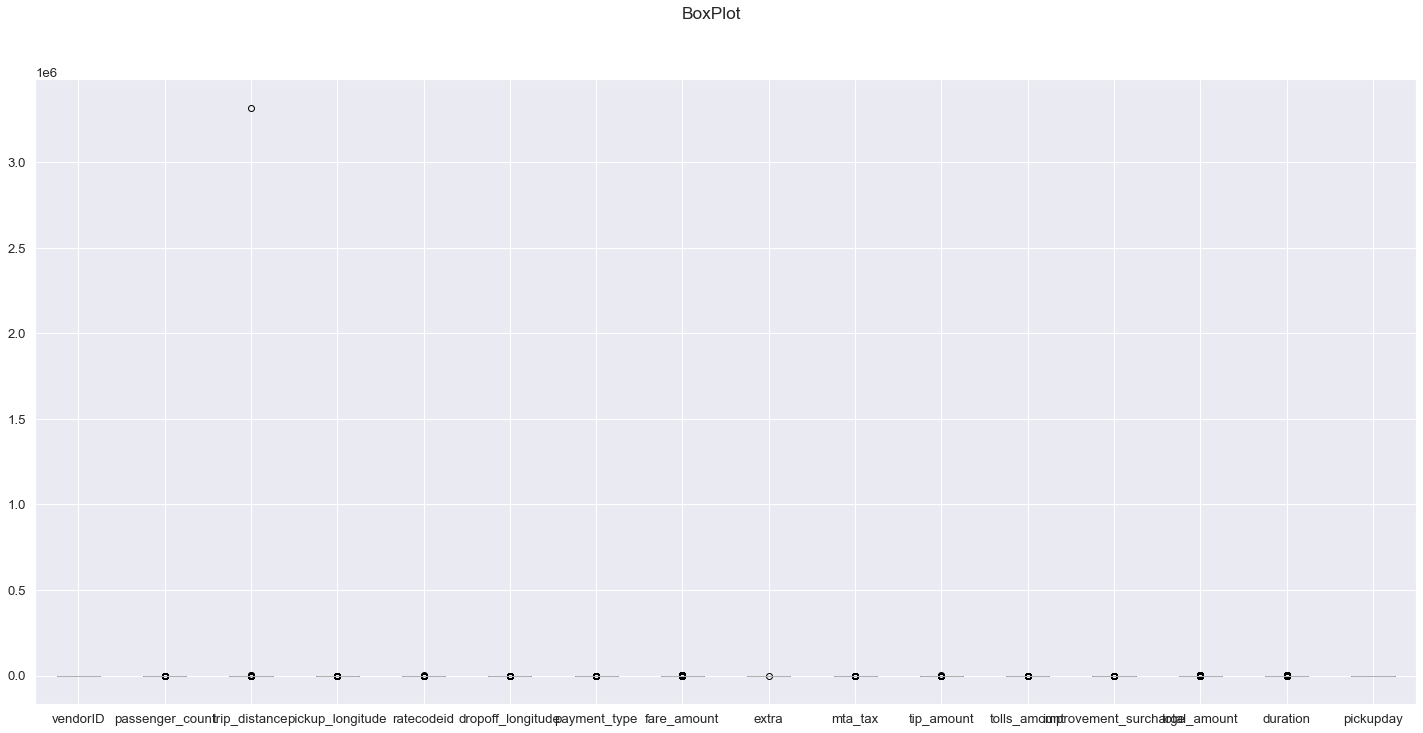

In [23]:
df.boxplot(figsize=(20,10))
plt.suptitle('BoxPlot', x=0.5, y=1.02, ha='center', fontsize='large')
plt.tight_layout()
plt.show()

In [24]:
df.columns

Index(['vendorID', 'pickup_time', 'dropoff_time', 'passenger_count', 'trip_distance', 'pickup_longitude', 'pickup_location', 'ratecodeid', 'store_and_fwd_flag', 'dropoff_longitude', 'dropoff_latitude', 'payment_type', 'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount', 'duration', 'pickupday'], dtype='object')

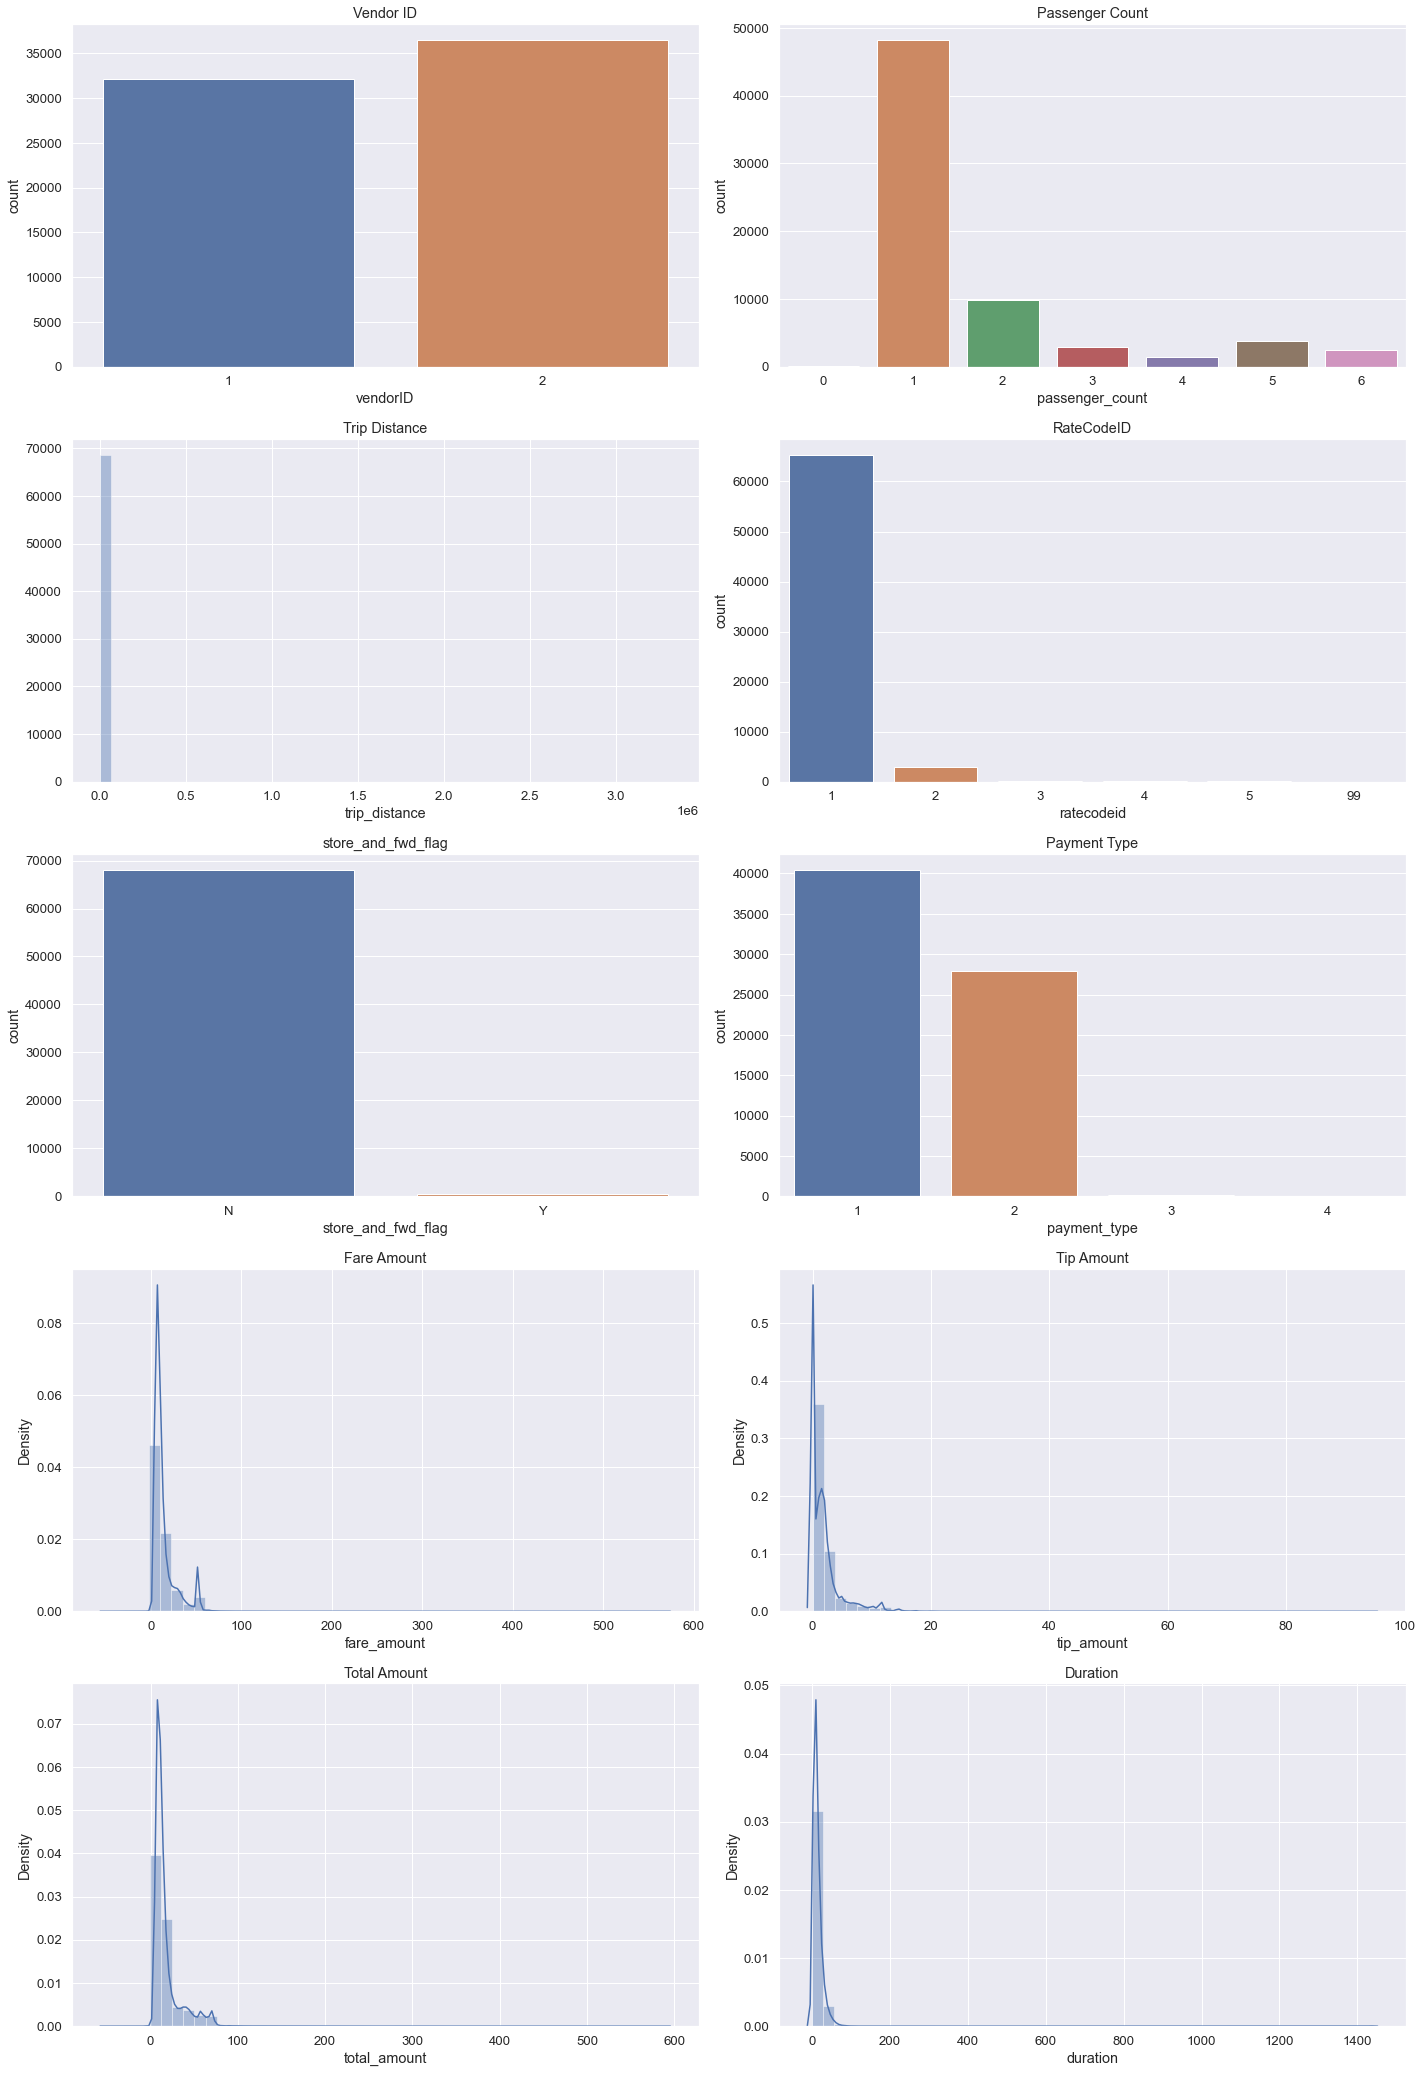

In [25]:
fig = plt.figure(figsize=(20,40))

plt.subplot(7,2,1)
plt.title("Vendor ID")
sns.countplot(x=df.vendorID)

plt.subplot(7,2,2)
plt.title("Passenger Count")
sns.countplot(x=df.passenger_count)

plt.subplot(7,2,3)
plt.title("Trip Distance")
sns.distplot(a=df.trip_distance, kde=False)

plt.subplot(7,2,4)
plt.title("RateCodeID")
sns.countplot(df.ratecodeid)

plt.subplot(7,2,5)
plt.title("store_and_fwd_flag")
sns.countplot(df.store_and_fwd_flag)

plt.subplot(7,2,6)
plt.title("Payment Type")
sns.countplot(df.payment_type)

plt.subplot(7,2,7)
plt.title("Fare Amount")
sns.distplot(df.fare_amount)

plt.subplot(7,2,8)
plt.title("Tip Amount")
sns.distplot(df.tip_amount)

plt.subplot(7,2,9)
plt.title("Total Amount")
sns.distplot(df.total_amount)

plt.subplot(7,2,10)
plt.title("Duration")
sns.distplot(df.duration)



plt.tight_layout()
plt.show()

In [26]:
df.head()

,vendorID,pickup_time,dropoff_time,passenger_count,trip_distance,pickup_longitude,pickup_location,ratecodeid,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,duration,pickupday
0,2,2015-01-29 20:30:00,2015-01-29 20:54:00,2,12.74,-73.790,JFK Airport,4,N,-73.655937,40.70500565,1,47.5,0.5,0.5,9.6,0.00,0.3,58.40,24.0,29
1,1,2015-01-01 17:21:00,2015-01-01 17:53:00,1,17.50,-73.790,JFK Airport,2,N,-73.992577,40.7533493,1,52.0,0.0,0.5,7.0,5.33,0.0,65.13,32.0,1
2,1,2015-01-18 01:08:00,2015-01-18 01:38:00,2,18.50,-73.782,JFK Airport,1,N,-73.885918,40.81613922,1,51.0,0.5,0.5,0.0,5.33,0.3,57.63,30.0,18
3,1,2015-01-13 16:08:00,2015-01-13 16:37:00,1,14.80,-73.788,JFK Airport,1,N,-73.940056,40.6059494,2,41.0,0.0,0.5,0.0,0.00,0.3,41.80,29.0,13
4,1,2015-01-29 00:42:00,2015-01-29 01:04:00,1,14.30,-73.779,JFK Airport,1,N,-73.908669,40.7676506,1,39.5,0.5,0.5,0.0,0.00,0.3,40.80,22.0,29


### Time-Series Analysis

In [27]:
timeseries = df[['pickup_time','passenger_count','trip_distance', 'total_amount','duration']]

In [28]:
timeseries.head()

,pickup_time,passenger_count,trip_distance,total_amount,duration
0,2015-01-29 20:30:00,2,12.74,58.40,24.0
1,2015-01-01 17:21:00,1,17.50,65.13,32.0
2,2015-01-18 01:08:00,2,18.50,57.63,30.0
3,2015-01-13 16:08:00,1,14.80,41.80,29.0
4,2015-01-29 00:42:00,1,14.30,40.80,22.0


In [29]:
timeseries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68568 entries, 0 to 68567
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   pickup_time      68568 non-null  object 
 1   passenger_count  68568 non-null  int64  
 2   trip_distance    68568 non-null  float64
 3   total_amount     68568 non-null  float64
 4   duration         68568 non-null  float64
dtypes: float64(3), int64(1), object(1)
memory usage: 2.6+ MB


In [30]:
timeseries["pickup_time"] = pd.to_datetime(timeseries["pickup_time"])

In [31]:
timeseries["dates"] = timeseries["pickup_time"].dt.date

In [32]:
timeseries.head()

,pickup_time,passenger_count,trip_distance,total_amount,duration,dates
0,2015-01-29 20:30:00,2,12.74,58.40,24.0,2015-01-29
1,2015-01-01 17:21:00,1,17.50,65.13,32.0,2015-01-01
2,2015-01-18 01:08:00,2,18.50,57.63,30.0,2015-01-18
3,2015-01-13 16:08:00,1,14.80,41.80,29.0,2015-01-13
4,2015-01-29 00:42:00,1,14.30,40.80,22.0,2015-01-29


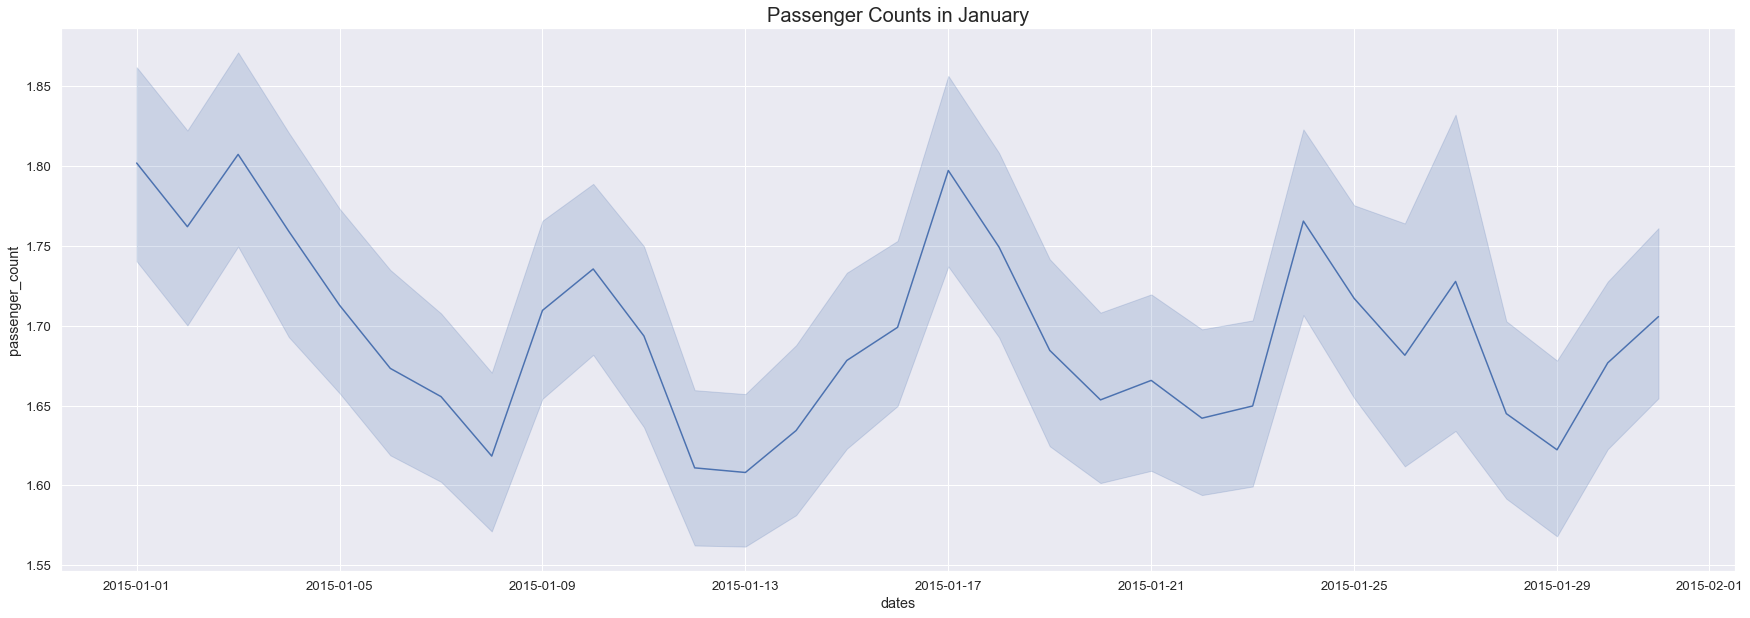

In [33]:
fig = plt.figure(figsize=(30,10))
sns.lineplot(x=timeseries.dates,y=timeseries.passenger_count,data=timeseries, estimator='mean')
plt.title("Passenger Counts in January", fontsize=20)
plt.show()

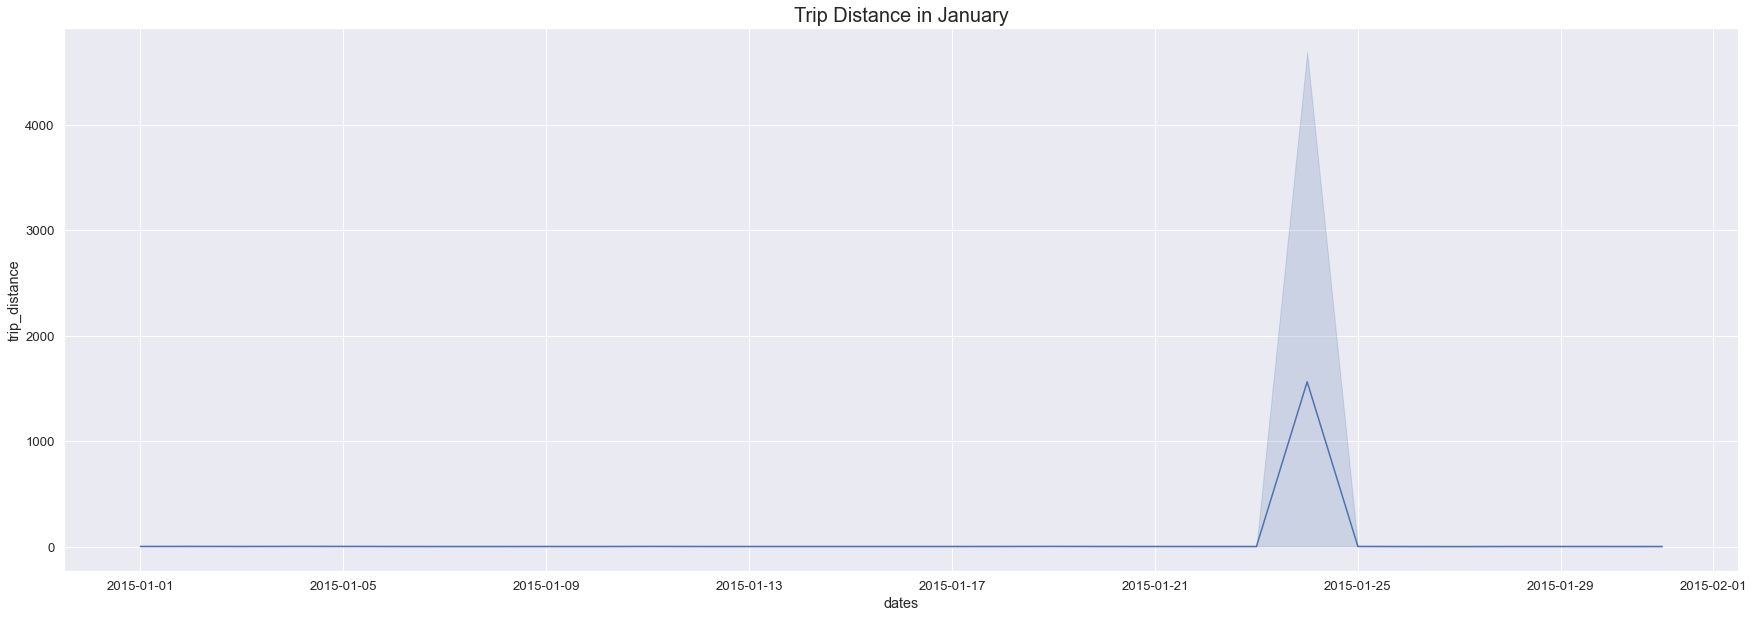

In [34]:
fig = plt.figure(figsize=(30,10))
sns.lineplot(x=timeseries.dates,y=timeseries.trip_distance,data=timeseries, estimator='mean')
plt.title("Trip Distance in January", fontsize=20)
plt.show()

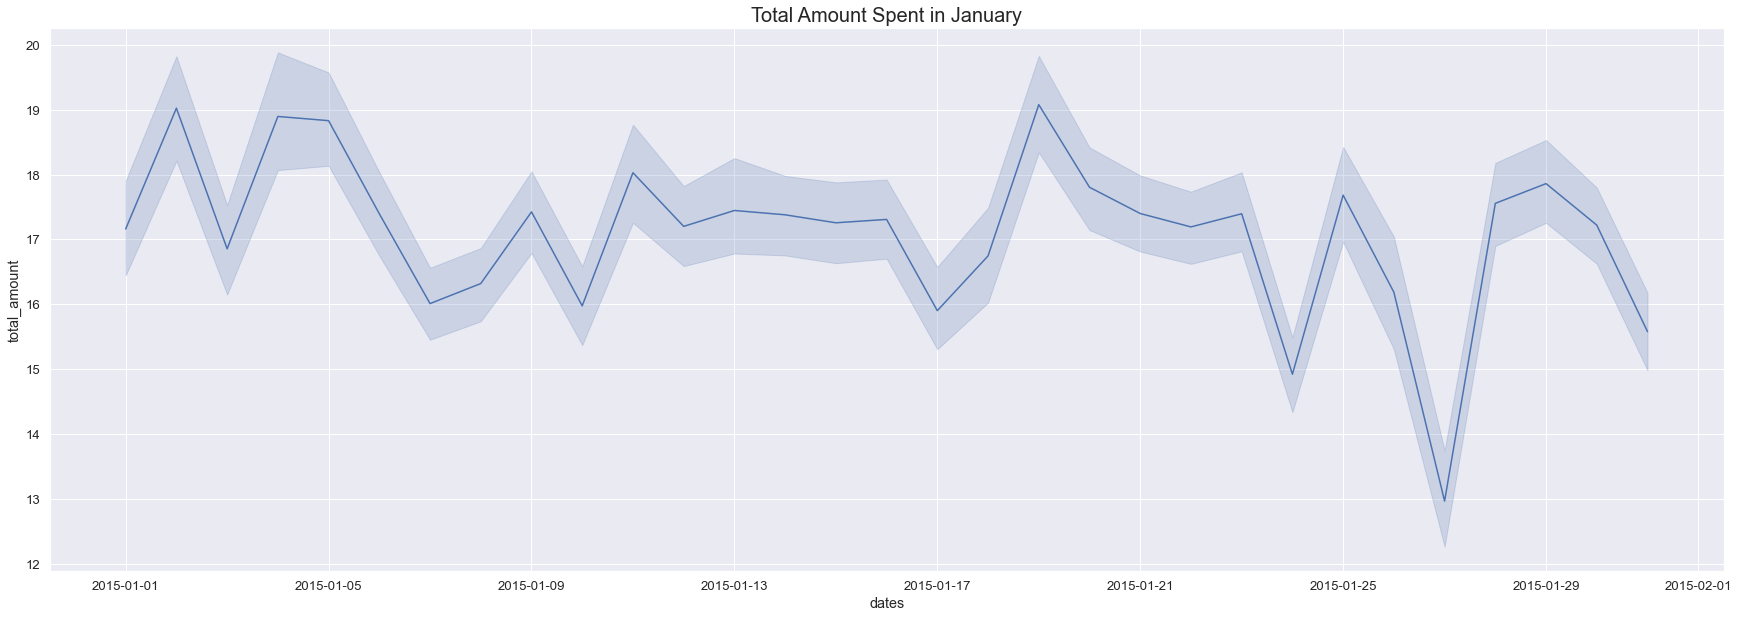

In [35]:
fig = plt.figure(figsize=(30,10))
sns.lineplot(x=timeseries.dates,y=timeseries.total_amount,data=timeseries, estimator='mean')
plt.title("Total Amount Spent in January", fontsize=20)
plt.show()

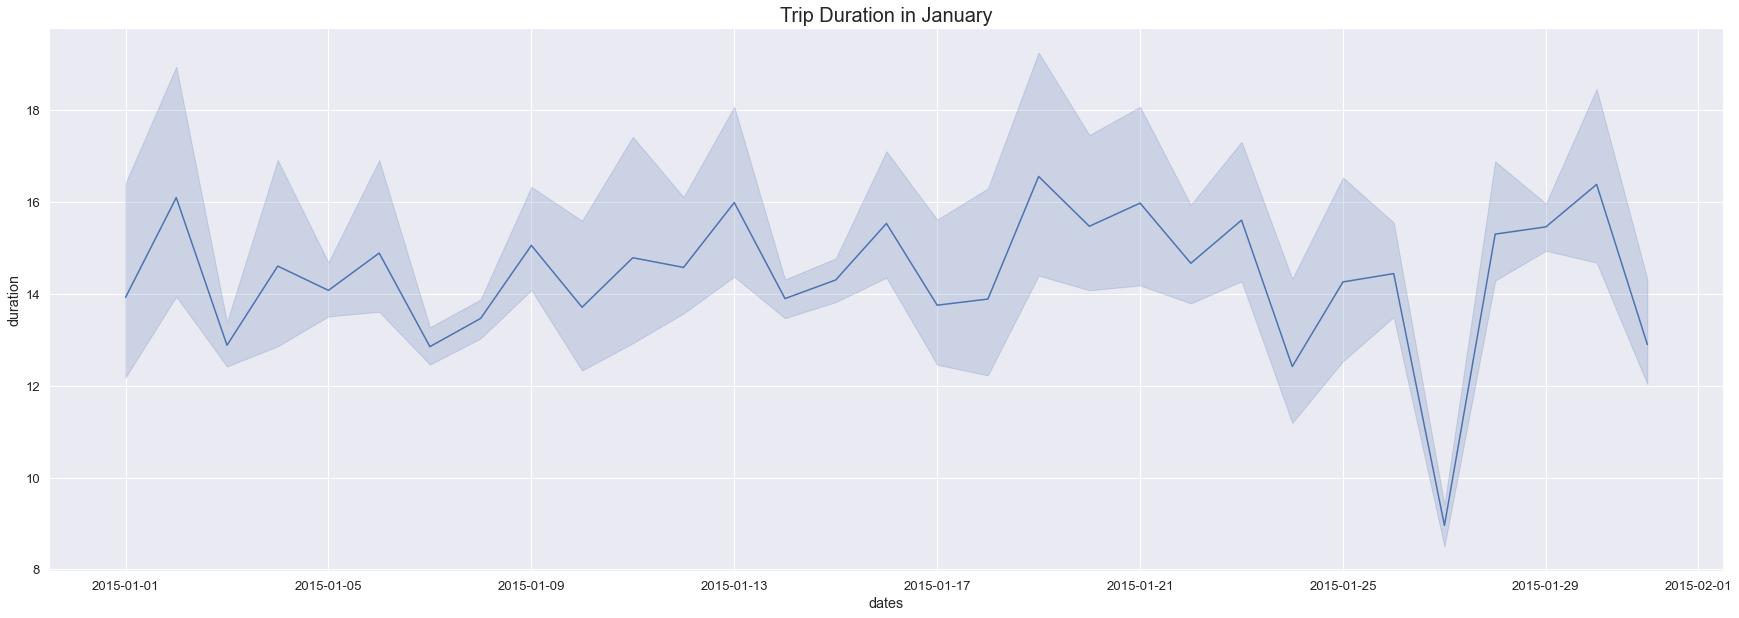

In [36]:
fig = plt.figure(figsize=(30,10))
sns.lineplot(x=timeseries.dates,y=timeseries.duration,data=timeseries, estimator='mean')
plt.title("Trip Duration in January", fontsize=20)
plt.show()

### Drop unwanted features

In [37]:
df.columns

Index(['vendorID', 'pickup_time', 'dropoff_time', 'passenger_count', 'trip_distance', 'pickup_longitude', 'pickup_location', 'ratecodeid', 'store_and_fwd_flag', 'dropoff_longitude', 'dropoff_latitude', 'payment_type', 'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount', 'duration', 'pickupday'], dtype='object')

In [38]:
df.drop(['vendorID', 'pickup_time', 'dropoff_time','pickup_longitude',
        'ratecodeid', 'store_and_fwd_flag', 'dropoff_longitude', 'dropoff_latitude',
        'payment_type','mta_tax','tolls_amount','improvement_surcharge'],axis=1,inplace=True)

In [39]:
df.head()

,passenger_count,trip_distance,pickup_location,fare_amount,extra,tip_amount,total_amount,duration,pickupday
0,2,12.74,JFK Airport,47.5,0.5,9.6,58.40,24.0,29
1,1,17.50,JFK Airport,52.0,0.0,7.0,65.13,32.0,1
2,2,18.50,JFK Airport,51.0,0.5,0.0,57.63,30.0,18
3,1,14.80,JFK Airport,41.0,0.0,0.0,41.80,29.0,13
4,1,14.30,JFK Airport,39.5,0.5,0.0,40.80,22.0,29


### Pairplots

<Figure size 1440x1440 with 0 Axes>

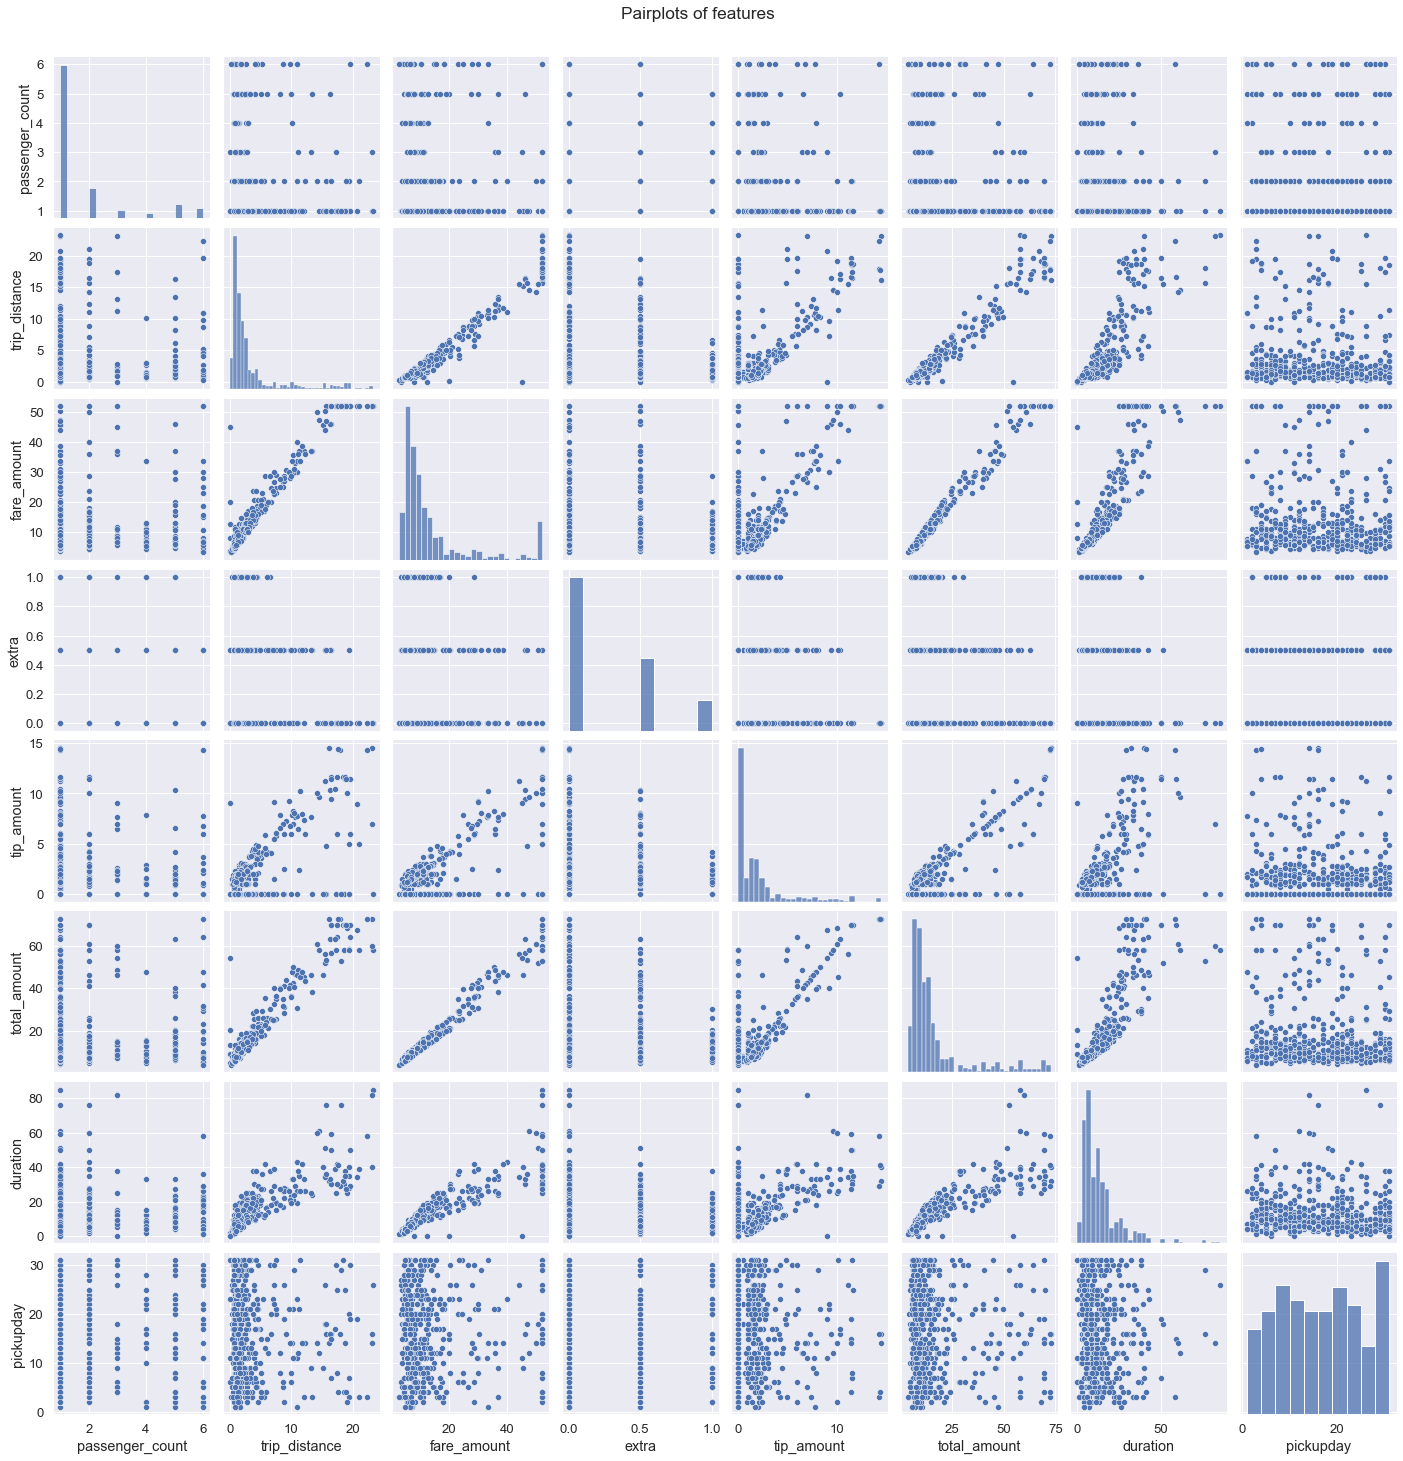

In [40]:
plt.figure(figsize=(20,20))
sns.pairplot(df.sample(500))
plt.suptitle('Pairplots of features', x=0.5, y=1.02, ha='center', fontsize='large')
plt.show()

### Correlation

In [41]:
df.corr()

,passenger_count,trip_distance,fare_amount,extra,tip_amount,total_amount,duration,pickupday
passenger_count,1.000000,-0.001952,0.013251,-0.004897,-0.009516,0.010623,0.015734,-0.012447
trip_distance,-0.001952,1.000000,0.000253,-0.003012,0.002720,0.000517,0.000451,0.003563
fare_amount,0.013251,0.000253,1.000000,-0.091227,0.604967,0.985443,0.261480,-0.021277
extra,-0.004897,-0.003012,-0.091227,1.000000,-0.034286,-0.066663,-0.026354,-0.005520
tip_amount,-0.009516,0.002720,0.604967,-0.034286,1.000000,0.715987,0.149022,0.014505
total_amount,0.010623,0.000517,0.985443,-0.066663,0.715987,1.000000,0.255307,-0.016650
duration,0.015734,0.000451,0.261480,-0.026354,0.149022,0.255307,1.000000,0.004476
pickupday,-0.012447,0.003563,-0.021277,-0.005520,0.014505,-0.016650,0.004476,1.000000


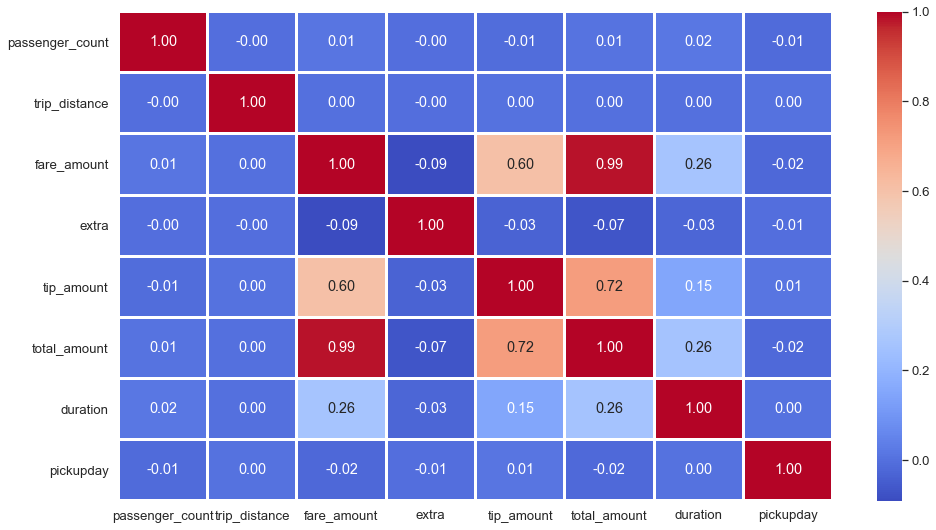

In [42]:
plt.figure(figsize=(16,9))
sns.heatmap(df.corr(),cmap="coolwarm",annot=True,fmt='.2f',linewidths=2)
plt.show()

## Generating the Grouped Summary Table

In [43]:
df.head()

,passenger_count,trip_distance,pickup_location,fare_amount,extra,tip_amount,total_amount,duration,pickupday
0,2,12.74,JFK Airport,47.5,0.5,9.6,58.40,24.0,29
1,1,17.50,JFK Airport,52.0,0.0,7.0,65.13,32.0,1
2,2,18.50,JFK Airport,51.0,0.5,0.0,57.63,30.0,18
3,1,14.80,JFK Airport,41.0,0.0,0.0,41.80,29.0,13
4,1,14.30,JFK Airport,39.5,0.5,0.0,40.80,22.0,29


In [44]:
df.groupby(by="pickup_location").count()

,passenger_count,trip_distance,fare_amount,extra,tip_amount,total_amount,duration,pickupday
pickup_location,,,,,,,,
JFK Airport,4543,4543,4543,4543,4543,4543,4543,4543
LaGuardia Airport,7291,7291,7291,7291,7291,7291,7291,7291
Lower Manhattan,5359,5359,5359,5359,5359,5359,5359,5359
Midtown,39799,39799,39799,39799,39799,39799,39799,39799
Upper East Side,11576,11576,11576,11576,11576,11576,11576,11576


In [45]:
df.groupby(by="pickup_location").mean()

,passenger_count,trip_distance,fare_amount,extra,tip_amount,total_amount,duration,pickupday
pickup_location,,,,,,,,
JFK Airport,1.723311,15.827086,45.730242,0.154083,5.482789,54.806604,37.469293,14.720889
LaGuardia Airport,1.713208,2.169347,10.048655,0.276574,1.286357,12.495809,11.498148,16.156769
Lower Manhattan,1.660011,2.389968,10.537768,0.264788,1.183129,12.891000,12.282889,16.070536
Midtown,1.681675,85.695150,10.734207,0.303525,1.358873,13.394238,12.237619,15.870801
Upper East Side,1.707326,4.349580,15.914592,0.291767,2.244106,20.330763,16.476676,15.855218


In [46]:
pd.pivot_table(data=df,index="pickupday", columns="pickup_location",values="trip_distance")

pickup_location,JFK Airport,LaGuardia Airport,Lower Manhattan,Midtown,Upper East Side
pickupday,,,,,
1,15.675694,2.482723,2.400328,2.614545,4.635681
2,17.003495,2.376033,2.464154,2.518840,4.788734
3,15.596782,2.221638,2.401524,2.268890,4.614954
4,15.929396,2.076474,2.255166,2.500315,5.545912
5,15.737974,1.880467,2.385109,2.285506,5.344487
6,15.337209,2.033790,2.115868,2.185674,4.414169
7,14.965779,2.149072,2.206111,2.088545,3.784818
8,16.088425,2.071107,2.307606,2.173746,4.077732
9,15.437233,2.143333,2.218564,2.380161,4.176550


In [47]:
pd.pivot_table(data=df,index="pickupday", columns="pickup_location",values="duration")

pickup_location,JFK Airport,LaGuardia Airport,Lower Manhattan,Midtown,Upper East Side
pickupday,,,,,
1,27.479167,9.881188,16.770492,10.962567,19.475083
2,35.677419,15.500000,20.769231,12.881279,14.158228
3,35.333333,9.836207,9.792683,10.405137,13.817337
4,39.258242,8.342105,18.086093,10.401737,14.764706
5,37.823276,9.817757,9.978261,10.422222,15.623077
6,31.994186,15.602740,11.035928,11.463166,19.808184
7,32.227273,11.156118,10.477778,11.061084,13.968370
8,38.669291,11.053571,11.718085,11.643944,14.741497
9,48.364780,11.174797,12.386740,12.194250,15.596737


In [48]:
pd.pivot_table(data=df,index="pickupday", columns="pickup_location",values="fare_amount")

pickup_location,JFK Airport,LaGuardia Airport,Lower Manhattan,Midtown,Upper East Side
pickupday,,,,,
1,44.954861,10.381683,9.895082,11.240062,16.148505
2,47.829570,10.606522,10.285385,11.261370,16.563924
3,44.649425,9.629310,10.091463,10.223695,15.874613
4,46.151099,9.578947,9.509934,10.645494,18.308824
5,45.672457,9.418224,10.296196,10.160905,18.179487
6,44.308140,9.826484,9.961078,10.296238,16.232737
7,43.344156,10.145570,10.416667,10.002196,14.336983
8,46.177165,10.185714,10.864362,10.433024,15.206349
9,45.467484,10.203252,10.356354,10.986676,15.568765


In [49]:
df.groupby("pickupday").sum()

,passenger_count,trip_distance,fare_amount,extra,tip_amount,total_amount,duration
pickupday,,,,,,,
1,3517,7526.93,27853.45,454.50,2820.88,33496.76,27184.0
2,3367,8191.55,29750.40,689.50,3141.60,36354.04,30767.0
3,3795,7852.29,29125.50,341.00,3162.88,35394.53,27058.0
4,3138,7822.61,27685.00,276.50,3210.69,33710.40,26061.0
5,3828,9353.73,33941.51,798.00,4128.27,42086.96,31468.0
6,3723,7951.61,30921.50,827.00,4117.21,38703.85,33135.0
7,4038,7809.73,31420.20,918.00,3907.01,39047.46,31350.0
8,4122,8139.78,33229.30,900.50,4306.20,41563.74,34304.0
9,4173,8569.19,33959.83,938.00,4409.72,42531.97,36761.0


In [50]:
df.groupby("pickupday").median()

,passenger_count,trip_distance,fare_amount,extra,tip_amount,total_amount,duration
pickupday,,,,,,,
1,1,2.000,9.50,0.0,0.00,11.300,10.0
2,1,1.900,9.70,0.0,0.00,11.800,11.0
3,1,1.740,9.00,0.0,0.00,10.550,10.0
4,1,2.000,9.25,0.0,0.70,11.150,10.0
5,1,1.800,9.00,0.0,1.00,11.300,10.0
6,1,1.650,9.00,0.5,1.00,11.600,11.0
7,1,1.580,9.00,0.5,1.00,11.300,10.0
8,1,1.600,9.00,0.0,1.00,11.300,10.0
9,1,1.640,9.50,0.5,1.00,11.750,11.0


In [51]:
df.groupby("pickupday").mean()

,passenger_count,trip_distance,fare_amount,extra,tip_amount,total_amount,duration
pickupday,,,,,,,
1,1.801742,3.856009,14.269185,0.232838,1.445123,17.160225,13.926230
2,1.761905,4.286525,15.567975,0.360806,1.643956,19.023569,16.099948
3,1.807143,3.739186,13.869286,0.162381,1.506133,16.854538,12.884762
4,1.758969,4.384871,15.518498,0.154989,1.799714,18.895964,14.608184
5,1.712752,4.185114,15.186358,0.357047,1.847101,18.830855,14.079642
6,1.673258,3.573757,13.897303,0.371685,1.850431,17.394989,14.892135
7,1.655597,3.202021,12.882411,0.376384,1.601890,16.009619,12.853629
8,1.618375,3.195830,13.046447,0.353553,1.690695,16.318704,13.468394
9,1.709545,3.510524,13.912261,0.384269,1.806522,17.423994,15.059812


In [52]:
demand_table = pd.DataFrame(df.groupby("pickupday").sum())

In [53]:
demand_table

,passenger_count,trip_distance,fare_amount,extra,tip_amount,total_amount,duration
pickupday,,,,,,,
1,3517,7526.93,27853.45,454.50,2820.88,33496.76,27184.0
2,3367,8191.55,29750.40,689.50,3141.60,36354.04,30767.0
3,3795,7852.29,29125.50,341.00,3162.88,35394.53,27058.0
4,3138,7822.61,27685.00,276.50,3210.69,33710.40,26061.0
5,3828,9353.73,33941.51,798.00,4128.27,42086.96,31468.0
6,3723,7951.61,30921.50,827.00,4117.21,38703.85,33135.0
7,4038,7809.73,31420.20,918.00,3907.01,39047.46,31350.0
8,4122,8139.78,33229.30,900.50,4306.20,41563.74,34304.0
9,4173,8569.19,33959.83,938.00,4409.72,42531.97,36761.0


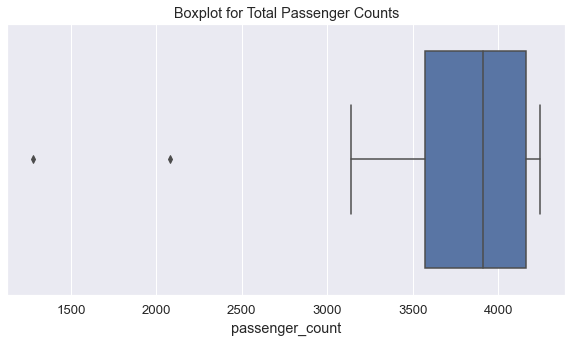

In [54]:
plt.figure(figsize=(10,5))
sns.boxplot(x=demand_table.passenger_count)
plt.title("Boxplot for Total Passenger Counts")
plt.show()

In [55]:
demand_table.describe()

,passenger_count,trip_distance,fare_amount,extra,tip_amount,total_amount,duration
count,31.000000,3.100000e+01,31.000000,31.000000,31.000000,31.000000,31.000000
mean,3739.000000,1.148858e+05,30610.553548,632.032581,3893.132258,37987.174194,32182.548387
std,638.268282,5.957181e+05,5815.284420,266.864700,921.688254,7411.661196,7074.092935
min,1275.000000,1.914890e+03,7496.500000,203.500000,957.840000,9566.990000,6612.000000
25%,3574.500000,7.722980e+03,28914.405000,352.250000,3270.110000,35171.875000,29265.500000
50%,3909.000000,8.191550e+03,31645.750000,798.000000,4128.270000,39047.460000,33225.000000
75%,4164.000000,8.644115e+03,34062.480000,854.500000,4612.720000,42677.380000,36673.000000
max,4244.000000,3.324700e+06,36611.130000,938.000000,4963.370000,45898.950000,42075.000000


In [56]:
df.shape

(68568, 9)

In [57]:
#df.to_csv("clean.csv",index=False)